# Plotting charts

In this notebook, we will show you create technical analysis charts with Capitalgram.

We will

* Download daily candle data for all pairs (several dozens of megabytes)

* Extract data for ETH-USDC pair on Uniswap v2

* Draw standard technical analysis charts like OHLC and OHLCV

* Plot static charts using [mplfinance](https://pypi.org/project/mplfinance/)

* Plot interactive charts using [Plotly](https://pypi.org/project/plotly/)

First let's import libraries and initialise our dataset client.

In [9]:
try:
    import capitalgram
except ImportError:
    !pip install -e git+https://github.com/miohtama/capitalgram-onchain-dex-quant-data.git#egg=capitalgram
    import site
    site.main()

# Pandas and Plotly are installed as capitalgram dependencies
import pandas as pd
import plotly.graph_objects as go
from capitalgram.client import Capitalgram
from capitalgram.candle import CandleBucket
import cufflinks as cf

capitalgram = Capitalgram.create_jupyter_client()

Started Capitalgram in Jupyter notebook environment, configuration is stored in /Users/moo/.capitalgram


Let's download 1 day (24h) candles to all trading pairs. This dataset is several dozens of megabytes.
You should see a progress bar during the download.

**Note**: We could also query live candle datasets for trading pairs we are interested in.
However, the bundled dataset is faster for the future analysis, as after the download
it will have all candles cached in your local notebook environment.

In [10]:
# Download all 24h candles as Parquet columnar data
all_candles = capitalgram.fetch_all_candles(CandleBucket.h24)

(Unknown total file size): 0it [00:00, ?it/s]

Let's pick one pair, ETH-USDC on Uniswap v2, from the dataset to analyse.

In [11]:
# Convert PyArrow table to Pandas format to continue working on it
all_candles_dataframe = all_candles.to_pandas()

# To shorten this notebook, we know by hearth that USDC-ETH Uniswap v2 is the pair id numero uno,
# because that what Hayden used to test the production code when he deployed Uniswap v2
pair_id = 1

eth_usdc_pair: pd.DataFrame = all_candles_dataframe.loc[all_candles_dataframe['pair_id'] == pair_id]

print(f"Uniswap v2 ETH-USDC has {len(eth_usdc_pair)} daily candles")


Uniswap v2 ETH-USDC has 433 daily candles


# Static charts with mplfinance

[mplfinance](https://pypi.org/project/mplfinance/) is a Jupyter Notebook library for financial charts.
It creates static charts out from Pandas data.

Pros

* Static chart images can be saved with notebook and are displayed e.g. on Github and the documentation website

Cons

* There is no interactive explorer controls like dragging timeline or zooming in.

Below we create a simple static chart from ETH-USDC price.

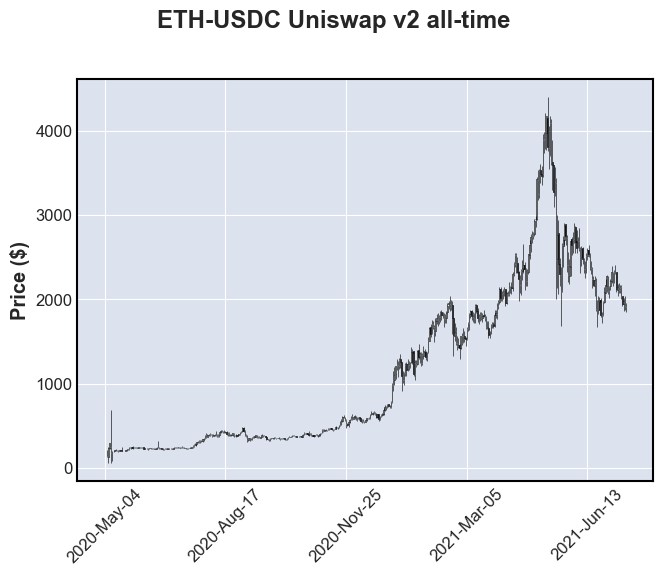

In [20]:
import mplfinance as fplt

# The data returned from the server is in latest first order and
# we need to reverse it, as all charts read from the left to right
# where the right is the latest
# https://stackoverflow.com/a/65391420/315168
eth_usdc_pair = eth_usdc_pair[::-1]

# Add a time based index to data series, as needed by mplfinance,
# so it knows which column is the x axis
eth_usdc_pair = eth_usdc_pair.set_index(pd.DatetimeIndex(eth_usdc_pair["timestamp"]))

fplt.plot(
            eth_usdc_pair,
            type='candle',
            title='ETH-USDC Uniswap v2 all-time',
            ylabel='Price ($)'
        )

As the daily candles are not that readable due to scale of the diagram, let's zoom in to October 2020, a randomly chosen month.

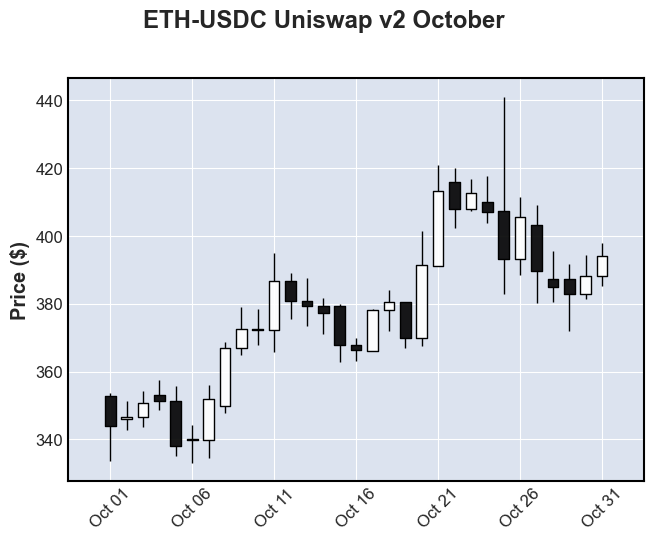

In [21]:
# Our filtering mask for the data
mask = (eth_usdc_pair.timestamp >= "2020-10-1") & (eth_usdc_pair.timestamp <= "2020-11-1")
october = eth_usdc_pair[mask]

# october = eth_usdc_pair.set_index(pd.DatetimeIndex(eth_usdc_pair["timestamp"]))

fplt.plot(
            october,
            type='candle',
            title='ETH-USDC Uniswap v2 October',
            ylabel='Price ($)'
        )

# Interactive charts with Plotly

**Note**: Interactive charts are not visible on documentation, Github or other statically rendered websites.
To see the interactive charts you need to run this notebook yourself. See instructions in Getting started
chapter.

Next, let's try interactive charts. You can pan and zoom into interactive charts, making them easier to explore.

In [14]:
# qf.iplot()

fig = go.Figure(data=[go.Candlestick(x=eth_usdc_pair['timestamp'],
                open=eth_usdc_pair['open'],
                high=eth_usdc_pair['high'],
                low=eth_usdc_pair['low'],
                close=eth_usdc_pair['close'])])
# fig.show()



Then we have OHCL chart

In [15]:
fig = go.Figure(data=[go.Ohlc(x=eth_usdc_pair['timestamp'],
                open=eth_usdc_pair['open'],
                high=eth_usdc_pair['high'],
                low=eth_usdc_pair['low'],
                close=eth_usdc_pair['close'])])

fig.show()

# Advanced quant charts with cufflinks

[Cufflinks]() is a library build on the top of Plotly.
It gives us some more useful chart formats for quantative analysis.

In [16]:
qf=cf.QuantFig(eth_usdc_pair, title='ETH-USDC Uniswap v2', legend='top', name='GS')
qf.add_bollinger_bands()
qf.add_volume()






